# 3.6.1 MNIST 데이터셋

이번 예에서는 MNIST라는 손글씨 숫자 이미지 집합을 이용할 것이다.<br>
데이터셋은 0부터 9까지 훈련용 이미지 60000장, 테스트용 이미지 10000장으로 이루어져 있고, 각 이미지는 $28 \times 28$의 행렬로 이루어져 있다.<br>
아래 코드를 이용해 깃허브 저장소로 부터 이미지를 받아올 수 있다.

첫번째 이미지를 출력하면 다음과 같다.

In [2]:
import sys, os
sys.path.append(os.pardir)
from source.dataset.mnist import load_mnist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

In [3]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


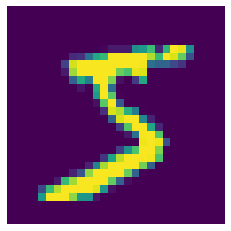

In [4]:
plt.imshow(x_train[0].reshape((28, 28)))
plt.axis("off")
plt.show()

# 3.6.2 신경망의 추론 처리

지금 부터 이 MNIST 데이터셋을 가지고 추론하는 신경망을 구현할 것이다. 이 신경망은 입력층 뉴런을 784개, 출력층 뉴런을 10개 가지고 있다. 한편, 은닉층은 총 두개인 3층 구조를 가지고, 첫번째 은닉층에는 50개의 뉴런을, 두번째 은닉층에는 100개의 뉴런을 가지도록 할 것 이다. 이 50과 100은 임의로 정한 숫자이다.<br>
순서대로 작업을 처리해줄 세 함수인 get_data(), init_network(), predict()를 정의 하자.

In [1]:
from functions import Function as F

In [5]:
import pickle

def get_data():
    (train_image, train_label), (test_image, test_label) \
    = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    
    return test_image, test_label

def init_network():
    with open("source/ch03/sample_weight.pkl", "rb") as f:
        network = pickle.load(f)
    
    return network

def predict(network, x):
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    b1, b2, b3 = network["b1"], network["b2"], network["b3"]
    
    a1 = x@W1 + b1
    z1 = F.sigmoid(a1)
    a2 = z1@W2 + b2
    z2 = F.sigmoid(a2)
    a3 = z2@W3 + b3
    y = F.softmax(a3)
    
    return y

In [6]:
x, t = get_data()
network = init_network()

accuracy_cnt = 0

for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y)
    if p == t[i]:
        accuracy_cnt += 1
        
print(f"Accuracy: {float(accuracy_cnt)/len(x)}")

Accuracy: 0.9352


우선 "get_data" 함수에서 load_mnist를 통해 받은 정보들을 각각 훈련 세트와 테스트 세트로 나누고, 그 중 테스트 세트만을 출력한다. 그리고 "init_network" 함수를 통해 사전에 계산된 가중치들을 통해 가중치 딕셔너리 "network"를 출력하고, 마지막으로 "predict"를 통해 신경망을 통과한 후 입력값이 0~9의 숫자들일 확률을 array의 형태로 출력한다. 이렇게 출력된 확률을 통해 가장 그럴싸한 숫자를 결정하고 이를 실제 label과 비교하여 정확도를 계산한다. 이 과정을 x에 담긴 모든 데이터에 대하여 시행한다.

그리고 "get_data" 함수 내부에 "load_mnist" 함수의 인자들중 "normalize"의 값이 True로 설정되어 있는데, 이는 0 ~ 255의 값을 가지는 데이터를 0.0 ~ 1.0 사이의 값을 가지도록 "정규화(normalize)" 시켜주는 과정이다. 간단하게 각 값들을 255로 나누면 된다. 이 과정은 "전처리(pre-processing)"이라고 한다.

# 3.6.3 배치 처리

In [7]:
x, _ = get_data()
network = init_network()
W1, W2, W3 = network["W1"], network["W2"], network["W3"]

print(x.shape)
print(W1.shape)
print(W2.shape)
print(W3.shape)

(10000, 784)
(784, 50)
(50, 100)
(100, 10)


이 결과로 부터 각 뉴런들의 대응하는 배열들의 차원이 일치하는 것을 볼 수 있는데, 그림으로는 다음과 같이 된다.
<img src="images/3_26.png" height="150px" width="500px">
데이터를 100장을 한번에 계산한다면 이와같다.
<img src="images/3_27.png" height="150px" width="500px">
그러므로 각각의 인덱스가 일치한다면 각각이 담고있는 데이터는 같은 대상에 대한 데이터가 된다. 그리고 이렇게 하나로 묶은 입력 데이터를 "배치(batch)"라고 한다.<br>
배치의 이점은 데이터의 연산을 더 빠르게 진행할 수 있게 해준다.
이 점을 이용해 위의 계산을 더 빠르게 수행해보자.

In [11]:
x, t = get_data()
network = init_network()

batch_size = 100
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])
        
print(f"Accuracy: {float(accuracy_cnt)/len(x)}")

Accuracy: 0.9352


In [12]:
x = np.array([[0.1, 0.8, 0.1], [0.3, 0.1, 0.6], [0.2, 0.5, 0.3], [0.8, 0.1, 0.1]])
y = np.argmax(x, axis=1)
print(x)
print(y)

[[0.1 0.8 0.1]
 [0.3 0.1 0.6]
 [0.2 0.5 0.3]
 [0.8 0.1 0.1]]
[1 2 1 0]
